Goal: To understand what happens when interest rate fluctuates over time. The model we will use is called the CIR [Cox Ingersoll Ross] model. The Vasicek model is very closely related to this.

The CIR model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek model to prevent negative interest rates.

$$ dr_i = a(b-r_i)dt + \sigma\sqrt{r_t}dW_t $$

The CIR model gives the small change in interest rate at time t. The change in interest rate is given by some parameter $a$ times $(b-r_t)$, which is the interest rate today ($r_t$) and some long-term mean for the interest rate. The difference shows you how far you are away from your long-term mean interest rate. $a$ is a parameter which tells how fast you would revert to the long-term interest rate. 

$b$ is the long-term mean interest rate and $a$ is the mean reversion speed.

If $a=0$ then the long-term mean rate has no role. When $a$ gets larger, it gets faster to revert to mean sooner than it would if $a$ was small.  

The term $𝑎(𝑏−𝑟_𝑖)𝑑𝑡$ represents the fact that changes in the interest rate depends on the distance from the long-term rate and the speed of mean reversion. $dt$ is the miniscule amount of time passed.

The second term represents a random normal $dW_t$ multiplied by a scaling factor $\sigma$, the volatility. If $\sigma$ is high, then you get large changes at each point in time. If $\sigma$ is small, then you get very small changes; if $\sigma = 0$, then there is no random effect. So, it is just a deterministic progression over time of the interest rate.

So, CIR is a mean reversion model where the changes in the interest rate are a function of how far you are from the long-term mean plus the shock, which is a function of sigma. If you ignore the $\sqrt{r_t}$, you will get the VASICEK MODEL. The $\sqrt{r_t}$ is just a way to prevent negative interest rates.

As  $\sqrt{r_t}$ nears zero, the shock amount has no impact, so the chances that you will just jump across to a negative number interest rate is very very small. 

## Short Rate vs Annalized

The short rate is the instantaneous rate that you get for a very small amount of time.

Assume you loaned 1$ with 100percent interest rate. At the end of year, you wil have to give back the principal (1dollar) plus the interest.

In [1]:
# At the end of year
1 + 1*(1)

2

If interest is calculated every six months, at the end of 6 months you will pay [1 + 1*(.5)]. Then after the next 6months, [1 + 1*(.5)] will be the principal.

In [2]:
# If Half yearly interest rate
1 + 1*(.5) + (1 + 1*(.5))*.5

2.25

In [3]:
# If quarterly
q1 = 1+1*(.25)
q2 = q1*.25
q3 = (q1+q2)*.25
q4 = (q1+q2+q3)*.25
# At the end of q4 you will pay
q1+q2+q3+q4

2.44140625

It is compounding and the interest rate is accruing at every single point in time.

The expression to compute the compounding; if we compound every $1/N$ of a year (i.e; N times a year) we get: 
$$\left(1+\frac{r}{N}\right)^N$$

In [4]:
# Half yearly
(1+1/2)**2

2.25

In [5]:
# Quarterly
(1+1/4)**4

2.44140625

In [6]:
(1+1/100)**100

2.7048138294215285

In [7]:
(1+1/10000)**10000 # This is value of e

2.7181459268249255

As the number of time between compoundings increases, it converges to a particular value

As N becomes very large we get the generalization:
    $$ 1 + r_{annual} = e^{r_{inst}} $$  
i.e; 
    $$ r_{annual} = e^{r_{inst}} - 1 $$
and 
    $$ r_{inst} = ln(1+r_{annual}) $$
    
    
r_{annual} --> Annual rate

r_{inst} --> Instantaneous rate or short rate


In [8]:
import numpy as np
import pandas as pd
import risk_kit as kit
%load_ext autoreload
%autoreload 2


def inst_to_ann(r):
    """
    Converts short rate to an annualized rate.
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annualized to short rate.
    """
    return np.log1p(r)

$$ dr_i = a(b-r_i)dt + \sigma\sqrt{r_t}dW_t $$

In [9]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates.
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)  # For small values of r, the instant rate and annualized rate are not that different.
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year) + 1 # The +1 is because of the row 0 in rate matrix.
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    
    rates = np.empty_like(shock)
    
    rates[0] = r_0
    
    # Simulate the changes in the rate
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)  #to make sure it is +ve.
        
    return pd.DataFrame(data = inst_to_ann(rates), index=range(num_steps))      

In [10]:
%matplotlib inline

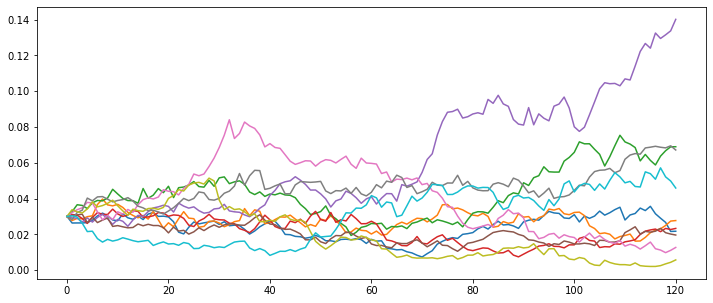

In [11]:
cir(n_scenarios=10).plot(figsize=(12,5), legend=False)

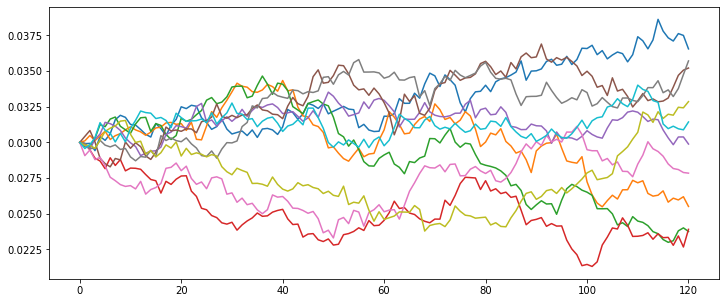

In [12]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

So you have been able to contain the growth of interest rates. 

In [13]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))
    


import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir, r_0=(0, .15, .01), a=(0, 1, .1), b=(0, .15, .01), 
                               sigma=(0, .1, .01), n_scenarios=(1,100))
display(controls)
                               

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

If the sigma is decreased, The interest rate goes up and it head towards a longterm mean. If the speed of mean reversion (a) increases, you will get to the long-term mean (b) faster.

Goal:

The goal is to use CIR model to see the effects of changes of interest rate. When interes rate change, what happens to the zero-coupon bond that we used as a hedge?


The CIR model can also be used to generate the movement of bond prices for a zero coupon bond that 
are implied by the general interest rate, using the following equatons:

$$ P(t, T) = A(t, T) e^{-B(t, T)r_{t}} $$

Where,

$$ A(t, T) = \left({\frac {2h e^{(a+h)\tau/2}}{2h + (a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t, T) = {\frac {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h = {\sqrt {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

The above equation gives the price of a bond at any time t, that matures at any time Capital T.

Now, update the CIR model to reurn the interest rates and the prices.

In [14]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model. b and r_0 are assumed to be 
    the annualized rates, not the short rate, The returned values are the annualized rates as well.
    """
    if r_0 is None: r_0=b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float.
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well
        prices[step] = price(n_years-step*dt, rates[step])
    
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ## For prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices
    
        

In [42]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))
    
controls = widgets.interactive(show_cir_prices, r_0=(0, .15, .01), a=(0, 1, .1), b=(0, .15, .01), 
                               sigma=(0, .1, .01), n_scenarios=(1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

As interest rates go up, the price of the zero-coupon bond goes down. If the interest rate (r_0) goes to zero and sigma is significantly decreased, the prices will be very close to each other. No matter what happens, the price will eventually converge to one. It doesn't matter what happens alongthe way. But alongthe way there can be a lot of variation in prices.

ie; The price of a zero-coupon bond can stay flat for a while, can go down or up as interest rate changes, eventually when the bond maturity is very, very short when you are close to maturity, it will end up being equal to one which is the amount of cash that the zero-coupon bond pays-off at maturity.  

**We have been able to build a model that changes interest rates, we have been able to figure out based on that model how prices change, and because we now know how prices change, we can simulate what would happen if we use zero-coupon bond as our hedge compared to if we use cash as our hedge.**


Assume that we have some assets

Cash on hand a_0 = $0.75 million.

Now, we'll simulate the next 10 years.

r_0 is the starting interest rate at 3%. Assume that the long-term interest rate is also 3%. 

Simulate 10 scenarios.


In [16]:
a_0 = 0.75
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)

# For simplicity, model the liabiities as equal to bond prices.
liabilities = bond_prices


What this means is that the liabilities are going to change over time. The idea is, my payoff or my liability that I am trying to match is one million dollars at the end of 10 years. Because the bond prices that I am simulating is actually a zero-coupon bond, what is going to happen is, as the price of that bond changes, the liabilities change appropriately.

In other words, as interest rateschange, the cost of paying off a dollar is my liability and the cost of paying off a dollar is also the bond price and therefore my liabilities are nothing more than the bond prices.

That is a trick used here, for me to model my liabilities changing over time, I'm just using nothing more than the changes in the prices of the zero-coupon bond because I know that they are basically the same thing. So now I can try and figure out what the price of a zero-coupon bond (zc_0) today is.


In [25]:
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = kit.pv(zcbond_10, r=0.03)

# The liability is the present value of paying off a dollar 10 years in the future. 
# The index is the time.

So I know exactly what the price of a zero-coupon bond today is. 10 years from now, it is nothing more than the present value of that dollar 10 years from now. 

So now I know, how much money I have - three quarters of a million. I have been able to simulate the changes in that liability over time. 

*The bond prices are nothing more than the evolution, the changes in the present value of that liability.*

I know what a zero-coupon bond costs today. So now, what wouldhappen if I took my 0.75 million, if I tool my assets and I put it in the zero-coupon bond? How many bonds could I buy? 

In [26]:
n_bonds = a_0/zc_0

Now, I have got the number of bonds and I also know how those bond prices are changing over time. So now I know how my asset value is going to do over time. 

Asset value (av_zc_bonds), assuming I put my money in a zero-coupon bond:


In [27]:
av_zc_bonds = n_bonds * bond_prices

Now, what if I put the 0.75 million in cash instead? Now, I'll compute the growth of 0.5 in cash. It will be whatever cash I have today times the interest rates. Those short rates are annualized, so have to divide by 12.

In [28]:
av_cash = a_0 * (rates/12 + 1).cumprod()

The growth of that 0.75 that I put in cash is the initial value times the array of interest rates ( t by n matrix where t is the number of steps and n is the number of simulated scenarios) and compound them. So now, I know exactly how much the value of the asset would be if I had invested in cash.

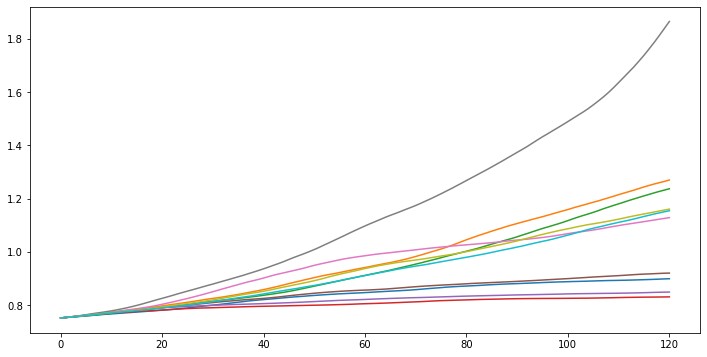

In [29]:
av_cash.plot(legend=False, figsize=(12,6))

This shows the evolution of my asset value in 10 different scenarios. 

As interest rates change, some of them do very well. If you put 0.75 million dollar incash, that is your hedge. Remember that the liability you are trying to matchis 1million dollar 10 years from now. The plot above shows that in some scenarios you might make it or in others, you might not make it.

*This illustrates that putting all your money in cash is not a safe hedge.*

So what if I put money in zero-coupon bonds?

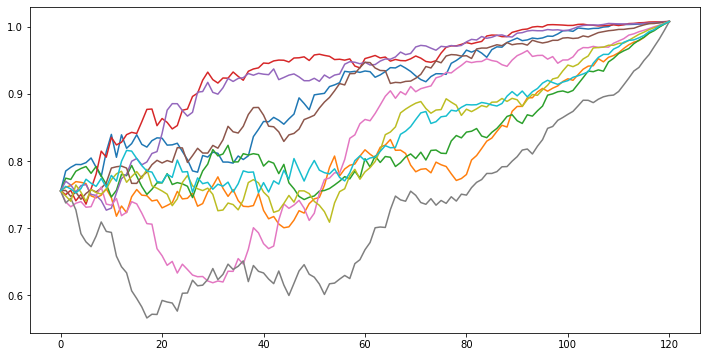

In [30]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

Here, I have been able to get to pretty much something very close to one or slightly higher. If you look at the value of porfolio, the cash one will seem like a very smooth ride up and it seems not risky. But that is the wrong way to look at it.

You should really look at the funding ratio.

#####  FUNDING RATIO

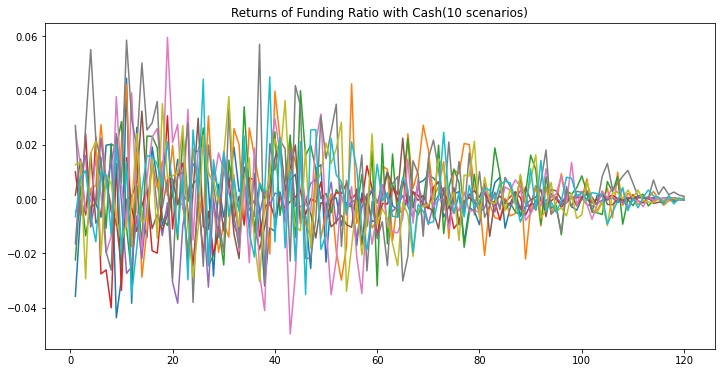

In [35]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash(10 scenarios)', 
                                               legend = False, figsize=(12,6))

The above plot illustrates the returns (pct_change) of the funding ratio (cash/liabilities).

It flutuates a lot in the beginning. But towards the end, it stabilizes. SO the returns on the funding ratio or the changes in the funding ratio, when I'm using cash as my asset is extremely volatile.

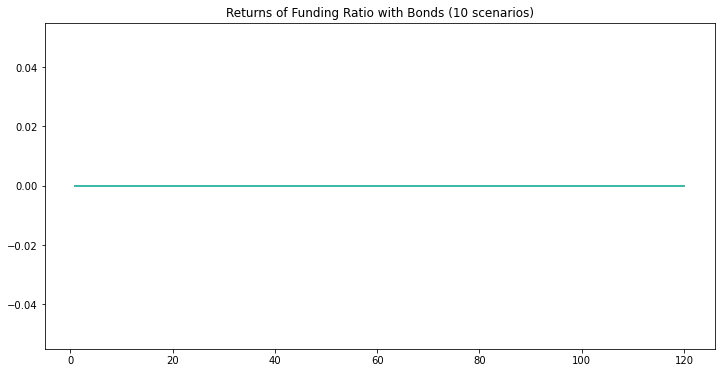

In [36]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Bonds (10 scenarios)', 
                                               legend = False, figsize=(12,6))

With Zero-Coupon bond portfolio, it is one simple flat line, ie; the funding ratio is steady. That is the beauty of using zero-coupon bonds as your funding vehicle to hedge your liabilities.


The challenge is even though the zero coupon bonds, if they eisted, would be fantastic hedge; they do exist, but they are actually not that easy for retail investors to buy. Even for institutional investors, it gets hard to find eactly the right liability matching set of zero-coupon bonds.

The main benefit of the zero-coupon bond is the fact that it doesnt fluctuate. It is less sensitive to interest rates, so that you will still end up where you need to end up, eventhough, it could fluctuate a lot in reaching there.

Now, look at Terminal Funding Ratio.

In [38]:
a_0 = 0.75 # asset value today
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03) # look at 10000 diff ways this could work out
liabilities = bond_prices
zc_0 = kit.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (rates/12 + 1).cumprod()

Terminal funding ratios show how the portfolio performs at the last bit. We are notinterested in the intermediate values.

In [40]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

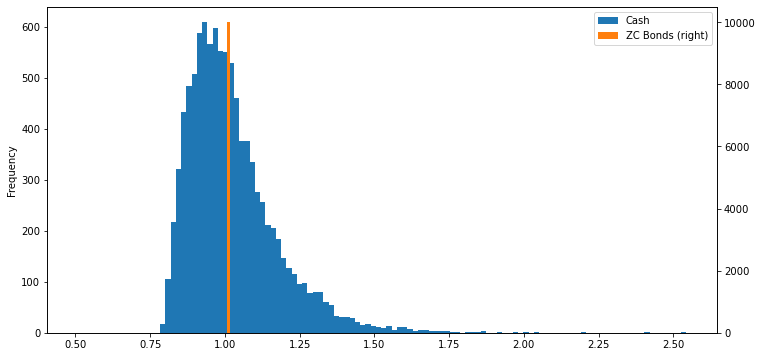

In [41]:
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(label="ZC Bonds", bins=100, legend=True, secondary_y=True)

This shows the spread of funding ratios if you put your asset as cash versus zero-coupon bond.